# Project CS - Shallow water model

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
%matplotlib inline

### MacCormak

Implement the MacCormack method.

This second-order finite difference method was introduced by Robert W. MacCormack in 1969. The MacCormack method is the simplest and elegant approach adapted to hyperbolic equations. This is a predictor-corrector approach, i.e. it predicts in the 1st step an intermediate solution $U_i^{*}$ which is then corrected in a 2nd step. 

The algorithm is

* predictor

$$U_i^{*} = U_i^n - {\Delta t \over \Delta x}  ( F_{i+1}^{n} - F_i^{n} )$$

* corrector

$$U_i^{n+1} = { 1 \over 2} (U_i^n + U_i^{*}) - { 1 \over 2}   {\Delta t \over \Delta x}  ( F_{i}^{*} - F_{i-1}^{*} )$$

The MacCormack algorithm does not introduce diffusive errors but it is known to be dispersive  (Gibbs phenomenon) in high gradient regions.

#### Parameters

In [2]:
# Numerical parameters

# --------------------------------------------------------

# space variables

# number of points to define the mesh
N = 200

# length of the mesh
L = 10.

# Spatial grid
x = np.linspace(0, L, N)
dx = L/len(x)

# --------------------------------------------------------

# time data

t0 = 0.
T  = 10.

dt = 0.004

# --------------------------------------------------------

# constant
g = 10.

CFL = dt/dx
CFL

0.08

##### $\eta$ functions

In [3]:
def eta0_zero(x):         
    
    """  Zero initial height """
    
    eta_0 = np.zeros((len(x)))
    
    return eta_0

def eta0_one(x):            
    
    """  One initial height """
    
    eta_0 = np.ones((len(x)))
    
    return eta_0

def eta0_slope(x):            
    
    """  Smooth slope """
    
    eta_0 = np.zeros((len(x)))
    eta_0 = 1. + .1*x
    
    return eta_0

def eta0_dam(x):    
    
    """  Discontinuous initial condition - dam like shape """
    
    # Data
    L      = x[-1]
    center = L/4
    
    eta_0 = np.zeros((len(x)))
    eta_0 = 1. + 0.2*(x<center)
    
    return eta_0

def eta0_bloc(x):    
    
    """  Bloc of water """
    
    # Initialisation
    eta_0 = np.zeros((len(x)))
    
    # Data
    L       = x[-1]
    delta_h = .15
    width   = L/3
    
    eta_0 = 1. + - delta_h*(x<(L/2-width/2)) - delta_h*(x>(L/2+width/2))
    
    return eta_0

##### f function

In [4]:
# Different possible bottom

def gaussian_bump(x, B0, sig, origin):

    """ Gaussian function, equivalent to a bump at the bottom """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    # ---------------------------------------------

    # functions
    f  = B0*np.exp(-((x - origin)**2)/(2*sig**2))
    df = (- B0 * (x - origin)/(sig**2)) * np.exp(-((x - origin)**2)/(2*sig**2))
    
    return (f, df)


def rect_bump(x):
    
    """ Rectangular bump function """
    
    # Initialisation
    f = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L = x[-1] # length mesh

    # ---------------------------------------------
        
    height  = 1.
    delta_h = .15
    width   = L/3
    
    # function
    f = delta_h*(x>(L/2-width/2))*(x<(L/2+width/2))
    df = np.zeros((len(x)))
    
    return (f, df)


def trian_bump(x):
    
    """ Triangular bump function """
    
    # Initialisation
    f = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L = x[-1] # length mesh
    
    height = 1.
    pick   = 1.5
    
    center = L/2
    width  = L/3
    
    slope  = (pick - height)/(center - (center-width/2))
    
    # ---------------------------------------------
    
    # functions
    idx_down = np.where((x>(center - width/2))*(x<center)) # indices where we are in wished zone
    idx_up   = np.where((x<(center + width/2))*(x>center)) # indices where we are in wished zone
    
    f[idx_down]  = + slope*(x[(x>(center - width/2))*(x<center)] - x[idx_down[0][0]])
    f[idx_up]    = - slope*(x[(x<(center + width/2))*(x>center)] - x[idx_up[-1][-1]])
    
    df[idx_down] = + slope
    df[idx_up]   = - slope

    return (f, df)

def slope_bump(x):
    
    """ Rectangular bump function """

    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L     = x[-1] # length mesh
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    f  = slope*x
    df = np.linspace(slope, slope, len(x))
    
    return (f, df)


def no_bump(x):
    
    """ No bump function """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # ---------------------------------------------
    
    # functions
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    return (f, df)

def one_bump(x):
    
    """ Elevated bottom function """

    # Initialisation
    f  = np.ones((len(x)))
    df = np.zeros((len(x)))
            
    return (f, df)

##### Right hand side member - S

In [5]:
def S(u, x, f, mu, rho, g, eps):

    #"" Shear stress + Topology ""

    # Splitting vector
    h = u[:,0].copy()
    q = u[:,1].copy()
       
    # -------------------------------------------------------------
    
    ## Initialisation
    tau = np.zeros((len(h), 2)) #len(h)=len(x)
    Bx  = np.zeros((len(h), 2)) #len(h)=len(x)
    df  = np.zeros((len(x)))

    # -------------------------------------------------------------
    
    # Data
    L  = x[-1]
    dx = L/len(x)

    # -------------------------------------------------------------
    
    ## Shearing coeff - Topology
    
    idx = (np.abs(h) > eps)

    tau[idx,1] = mu*3*q[idx]/h[idx]**2
    df[1:-1]   = (f[2:] - f[:-2])/(2*dx)
    
    Bx[idx, 1] = g*h[idx]*df[idx]

    ## Right hand side vector S
    S = -Bx - tau/rho

    return S

##### Flux vector

In [6]:
def fill_F(U, g, eps):
    
    """  Fill Flux vector of equations """
        
    F = np.zeros_like((U))   
    
    # -------------------------------
    
    idx = (np.abs(U[:,0])>eps)
    
    # -------------------------------
    
    F[idx,0] = U[idx,1]
    F[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2
    
    return F

# ---------------------------------------------------------------------------------------------------------------------

"""
def fill_F_HLL_RUS(Flux, U, g, eps):
    
    #""  Fill Flux vector - HLL ""
    
    idx = (np.abs(U[:,0]) > eps)

    # -------------------------------

    # Sizes
    size_U_row = np.size(U,0)

    # -------------------------------

    ## Initialisation
    
    # fluxes
    F_HLL = np.zeros_like(U)
    F     = np.zeros_like(U) 
    F_R   = np.zeros_like(U)
    F_L   = np.zeros_like(U)    

    # velocities
    size_U = np.size(U,0)
    
    S_L = np.zeros(size_U)
    S_R = np.zeros(size_U)
    
    # U = [h, q]^T
    U_L = np.zeros_like(U)
    U_R = np.zeros_like(U)
    
    ## 1st --------------------------
    
    F_HLL[:,0]   = U[:,1]
    F_HLL[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2

    ## 2nd --------------------------

    # fluxes
    F_L[1:-1,:] = F_HLL[:-2,:]
    F_R[1:-1,:] = F_HLL[2:,:]
    
    # U = [h, q]^T
    U_L[1:-1] = U[:-2,:]
    U_R[1:-1] = U[2:,:]
    
    # velocities
    S_L[1:-1] = U_L[1:-1,1]/U_L[1:-1,0] - np.sqrt(g*U_L[1:-1,0])
    S_R[1:-1] = U_R[1:-1,1]/U_R[1:-1,0] + np.sqrt(g*U_R[1:-1,0])
    
    ## 3rd -----------------------
    
    size_S = np.size(S_L, 0)
    
    for k in range(1, size_S-1):
        if S_L[k]>=0:
            F_HLL[k,:] = F_L[k,:]
            
        elif S_R[k]<=0:
            F_HLL[k,:] = F_R[k,:]
            
        elif S_L[k]<0 and S_R[k]>0:
            F_HLL[k,:] = (S_R[k]*F_L[k,:] - S_L[k]*F_R[k,:] + S_L[k]*S_R[k]*(U_R[k,:] - U_L[k,:]))/(S_R[k]-S_L[k])
            
        else:
            1==0
    
    #F_HLL[S_L>=0] = F_L[S_L>=0]
    #F_HLL[S_R<=0] = F_R[S_R<=0]
    #F_HLL[(S_R>0)&(S_L<0)] = ((S_R*F_L - S_L*F_R + S_L*S_R*(U_R - U_L))[(S_R>0)&(S_L<0)])/(S_R-S_L)[(S_R>0)&(S_L<0)]
        
    return F_HLL[idx,:]

"""

def fill_F_HLL_RUS(F, U, g, eps):
    
    #""  Fill Flux vector of equations ""
    
    idx = (np.abs(U[:,0])>eps)
    
    # -------------------------------

    # fluxes
    F_HLL = np.zeros_like(F)
    
    # velocities
    S_L = np.zeros(U.shape)    
    S_R = np.zeros(U.shape)
    
    # velocities
    S_L[idx,0] = S_L[idx,1] = U[idx,1]/U[idx,0] - np.sqrt(g*U[idx,0])
    S_L[:-1,:] = np.minimum(S_L[:-1,:], S_L[1:,:])
    
    S_R[idx,0] = S_R[idx,1] = U[idx,1]/U[idx,0] + np.sqrt(g*U[idx,0])
    S_R[:-1,:] = np.maximum(S_R[:-1,:], S_R[1:,:])
    
    # u = [h; q]
    U_R = U.copy()
    U_R[:-1,:] = U[1:,:]
    
    # --------------------------
    
    # fluxes
    F_L = F.copy()   
    F_R = F.copy()
    F_R[:-1,:] = F[1:,:]

    F_HLL[S_L>=0] = F_L[S_L>=0]
    F_HLL[S_R<=0] = F_L[S_R<=0]
    F_HLL[(S_R>0)&(S_L<0)] = ((S_R*F_L - S_L*F_R + S_L*S_R*(U_R - U))[(S_R>0)&(S_L<0)])/(S_R-S_L)[(S_R>0)&(S_L<0)]
    
    return F_HLL

# ---------------------------------------------------------------------------------------------------------------------


def BC(U):
    
    #""  Boundary conditions ""
    
    # Height
    U[0,0]  = U[1,0]
    U[-1,0] = U[-2,0]
    
    # Flux
    U[0,1]  = 0 #U[1,1]
    U[-1,1] = 0 #U[-2,1] #2*U[-2,1]-U[-3,1]
    
    return U

#### System solver

In [7]:
# Matrix/Operator version

import scipy.sparse as sp

# --------------------------------------------------------

def diverg_up_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [0, 1], (m, m)).toarray()
    
    Div[0,1] = 0
    Div[0,0] = Div[-1,-1] = 1
   
    return Div

def diverg_down_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [-1, 0], (m, m)).toarray()
    
    Div[-1,-2] = 1
    
    return Div


## Algo

def q_MC(x, dx, t0, T, dt, u_ini, f, g, rho, mu, eps):

    """  The MacCormak method """
    
    u      = u_ini.copy()
    BC(u)
    
    h      = [u[:,0].copy()] # h variable
    q      = [u[:,1].copy()] # q variable
    
    # -------------------------------------------
    
    Div_down = diverg_down_op(len(u[:,0]))
    Div_up   = diverg_up_op(len(u[:,0]))
    
    # -------------------------------------------
    
    npas = int(T/dt)
    t      = t0
    i      = 0
    
    while i < npas:
        
        i += 1
        t += dt
            
        # predictor solution
        F      = fill_F(u, g, eps)
        F_HLL  = fill_F_HLL_RUS(F, u, g, eps)
        u_star = u - (dt/dx)*Div_up@F_HLL + dt*S(u, x, f, mu, rho, g, eps)
        
        # Periodic BCs:
        BC(u_star)
        
        # ------------------------------------------------------------------------------------------------
        
        # corrector solution
        F_star      = fill_F(u_star, g, eps)
        F_HLL_star  = fill_F_HLL_RUS(F_star, u_star, g, eps)
        unew        = .5*(u+u_star) - .5*(dt/dx)*Div_down@F_HLL_star + dt*S(u_star, x, f, mu, rho, g, eps)
        
        # Periodic BCs:
        BC(unew)
        
        if (i%30)==0: #We only take some values (every a in i%a)
            h.append(unew[:,0].copy()) # vector containing h(x,T) for each iteration
            q.append(unew[:,1].copy()) # vector containing h(x,T) for each iteration
        
        u = unew.copy()         # vector containing u(x,T)
    
    return (h, q, t)

##### Initialisation

In [8]:
## Chose bottom

# Data bump

# Length
L      = x[-1]

# Height
B0     = 5.0

# Width
sig    = .5

# Origin
origin = L/2

(B, Bx) = gaussian_bump(x, B0, sig, origin)

# --------------------------------------------

## Chose initial state

# Initial eta
eta0 = eta0_slope(x).reshape(-1,1)
f    = B.reshape(-1,1)

# Initial height
h0   = f
h0   = (eta0 - f)*(eta0>f)

# Initial flux
q0   = np.zeros((len(x)))
q0   = q0.reshape(-1, 1)

# Concatenation
u_ini = np.append(h0, q0, axis=1)

#### Solving dry state

In [9]:
# Data
mu  = 10**-3
rho = 10**3 #[kg.m-3] water volumic mass

# Time of study
T   = 30.

# Precision over height
eps = 10**-1

# -----------------------------------------------------------------

# Height and flux
(h, q, t_final) = q_MC(x, dx, t0, T, dt, u_ini, B, g, rho, mu, eps)

# Speed
u = np.array(q)/np.array(h)

print('\nWe check for stability')
print('At final time t = {:.0f} s\n'.format(t_final))
print('H_final(x=L) = {} \n'.format(h[-1][-1:]))
print('Q_final(x=L) = q(x, {:.0f}) = {}'.format(t_final, q[-1][-1:]))

<ipython-input-6-b530e75d1d8e>:112: RuntimeWarning: invalid value encountered in sqrt
  S_L[idx,0] = S_L[idx,1] = U[idx,1]/U[idx,0] - np.sqrt(g*U[idx,0])
<ipython-input-6-b530e75d1d8e>:115: RuntimeWarning: invalid value encountered in sqrt
  S_R[idx,0] = S_R[idx,1] = U[idx,1]/U[idx,0] + np.sqrt(g*U[idx,0])
<ipython-input-6-b530e75d1d8e>:129: RuntimeWarning: invalid value encountered in greater_equal
  F_HLL[S_L>=0] = F_L[S_L>=0]
<ipython-input-6-b530e75d1d8e>:130: RuntimeWarning: invalid value encountered in less_equal
  F_HLL[S_R<=0] = F_L[S_R<=0]
<ipython-input-6-b530e75d1d8e>:131: RuntimeWarning: invalid value encountered in greater
  F_HLL[(S_R>0)&(S_L<0)] = ((S_R*F_L - S_L*F_R + S_L*S_R*(U_R - U))[(S_R>0)&(S_L<0)])/(S_R-S_L)[(S_R>0)&(S_L<0)]
<ipython-input-6-b530e75d1d8e>:131: RuntimeWarning: invalid value encountered in less
  F_HLL[(S_R>0)&(S_L<0)] = ((S_R*F_L - S_L*F_R + S_L*S_R*(U_R - U))[(S_R>0)&(S_L<0)])/(S_R-S_L)[(S_R>0)&(S_L<0)]



We check for stability
At final time t = 30 s

H_final(x=L) = [1.65763081] 

Q_final(x=L) = q(x, 30) = [0.]


<ipython-input-9-3a8174f731a2>:17: RuntimeWarning: invalid value encountered in true_divide
  u = np.array(q)/np.array(h)


#### Animation - Smooth IC

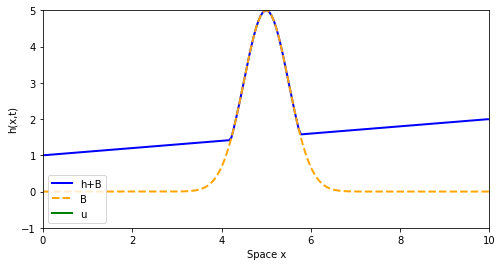

In [10]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(h)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h
line2, = ax.plot([], [], '--', color='orange', linewidth=2)  # Line plot for B
line3, = ax.plot([], [], 'g-', linewidth=2)  # Line plot for u

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((0, 10, -1, 5))              # Set the bounds of the plot

def plot_q(n):
    line1.set_data(x, (h+B)[n])
    line2.set_data(x, B)
    #line3.set_data(x, u[n])

    return[line1, line2, line3]
    
anim = animation.FuncAnimation(fig, plot_q, frames=n)  # Animate the solution

plt.legend(['h+B', 'B', 'u'], loc=3)

#plt.show()
HTML(anim.to_jshtml())

### Ruzanov

##### Initialisation

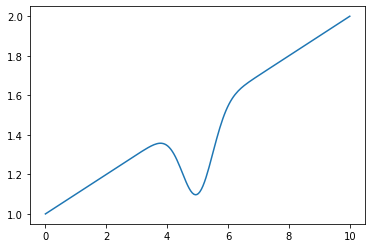

In [16]:
## Chose bottom

# Data bump

# Length
L      = x[-1]

# Height
B0     = .4

# Width
sig    = .5

# Origin
origin = L/2

(B, Bx) = gaussian_bump(x, B0, sig, origin)

# --------------------------------------------

## Chose initial state

# Initial eta
eta0 = eta0_slope(x).reshape(-1,1)
f    = B.reshape(-1,1)

# Initial height
h0   = f
h0   = (eta0 - f)*(eta0>f)

# Initial flux
q0   = np.zeros((len(x)))
q0   = q0.reshape(-1, 1)

# Concatenation
u_ini = np.append(h0, q0, axis=1)

# --------------------------------------------

plt.figure()
plt.plot(x, h0)

##### Rusanov flux vector - BC

In [17]:
"""
def fill_F_RUS(U, g, eps):
    
    ""  Fill Flux vector of equations ""
    
    # Sizes
    size_U_row = np.size(U,0)
    size_U_col = np.size(U,1)

    # -------------------------------

    ## Initialisation
    
    # fluxes
    F   = np.zeros_like((U))    
    F_L = np.zeros_like((U))    
    F_R = np.zeros_like((U))
    
    # velocities
    S      = np.zeros((size_U_row))
    S_L_UL = np.zeros((size_U_row))   
    S_L_UR = np.zeros((size_U_row))
    S_R_UL = np.zeros((size_U_row))
    S_R_UR = np.zeros((size_U_row))
    
    # u = [h; q]
    U_L = np.zeros_like((U))
    U_R = np.zeros_like((U))

    # -------------------------------
        
    idx = (np.abs(U[:,0]) > eps)
    #idx = idx.astype(int)
    
    ## 1st --------------------------
    
    F[:,0]   = U[:,1]
    F[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2
        
    ## 2nd --------------------------
    
    # U = [h; q]
    U_L[1:-1,:] = U[:-2,:]
    U_R[1:-1,:] = U[2:,:]
    
    # fluxes
    F_L[1:-1,:] = F[:-2,:]
    F_R[1:-1,:] = F[2:,:]
    
    # velocities
    S_L_UL[idx[1:-1]] = U_L[idx[1:-1],1]/U_L[idx[1:-1],0] - np.sqrt(g*U_L[idx[1:-1],0])
    S_L_UR[idx[1:-1]] = U_R[idx[1:-1],1]/U_R[idx[1:-1],0] - np.sqrt(g*U_R[idx[1:-1],0])
    S_R_UL[idx[1:-1]] = U_L[idx[1:-1],1]/U_L[idx[1:-1],0] + np.sqrt(g*U_L[idx[1:-1],0])
    S_R_UR[idx[1:-1]] = U_R[idx[1:-1],1]/U_R[idx[1:-1],0] + np.sqrt(g*U_R[idx[1:-1],0])
                
    # 3rd -----------------------
    
    for k in range(1,len(idx)-1):
        S[k] = max(S_L_UL[k], S_L_UR[k], S_R_UL[k], S_R_UR[k])
        F[k, 0] = .5*(F_L[k, 0] + F_R[k, 0]) - .5*S[k]*(U_R[idx[k], 0] - U_L[idx[k], 0])
        F[k, 1] = .5*(F_L[k, 1] + F_R[k, 1]) - .5*S[k]*(U_R[k, 1] - U_L[k, 1])
    
    return F

def BC(U):
    
    ""  Boundary conditions ""
    
    # Height
    U[0,0]  = U[1,0]
    U[-1,0] = U[-2,0]
    
    # Flux
    U[0,1]  = -U[1,1] #U[1,1]
    U[-1,1] = -U[-2,1] #U[-2,1] #2*U[-2,1]-U[-3,1]
    
    return
"""

'\ndef fill_F_RUS(U, g, eps):\n    \n    ""  Fill Flux vector of equations ""\n    \n    # Sizes\n    size_U_row = np.size(U,0)\n    size_U_col = np.size(U,1)\n\n    # -------------------------------\n\n    ## Initialisation\n    \n    # fluxes\n    F   = np.zeros_like((U))    \n    F_L = np.zeros_like((U))    \n    F_R = np.zeros_like((U))\n    \n    # velocities\n    S      = np.zeros((size_U_row))\n    S_L_UL = np.zeros((size_U_row))   \n    S_L_UR = np.zeros((size_U_row))\n    S_R_UL = np.zeros((size_U_row))\n    S_R_UR = np.zeros((size_U_row))\n    \n    # u = [h; q]\n    U_L = np.zeros_like((U))\n    U_R = np.zeros_like((U))\n\n    # -------------------------------\n        \n    idx = (np.abs(U[:,0]) > eps)\n    #idx = idx.astype(int)\n    \n    ## 1st --------------------------\n    \n    F[:,0]   = U[:,1]\n    F[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2\n        \n    ## 2nd --------------------------\n    \n    # U = [h; q]\n    U_L[1:-1,:] = U[:-2,:]\n    U_R[1:-1,

In [18]:
def fill_F_HLL_RUS(F, U, g, eps):
    
    """  Fill Flux vector of equations """
    
    # Size
    size_U_row = np.size(U,0)

    # -------------------------------

    ## Initialisation
    
    # fluxes
    F_RUS = np.zeros_like(F)    
    F_L   = np.zeros_like(F)
    F_R   = np.zeros_like(F)
    
    # velocities
    S      = np.zeros((size_U_row))
    S_L_UL = np.zeros((size_U_row))   
    S_L_UR = np.zeros((size_U_row))
    S_R_UL = np.zeros((size_U_row))
    S_R_UR = np.zeros((size_U_row))
    
    # u = [h; q]
    U_L = np.zeros_like(U)
    U_R = np.zeros_like(U)

    # -------------------------------
    
    idx = np.where(U[:,0]>eps)[0]
    
    ## 1st --------------------------
    
    # U = [h; q]
    #U_L[1:-1,:] = U[:-2,:]
    #U_R[1:-1,:] = U[2:,:]
    
    # fluxes
    
    #F_L[1:-1,:] = F[:-2,:]
    #F_R[1:-1,:] = F[2:,:]
    
    # u = [h; q]
    U_L = U.copy()
    U_R = U.copy()
    U_R[:-1,:] = U[1:,:]
    
    # fluxes
    F_L = F.copy()   
    F_R = F.copy()
    F_R[:-1,:] = F[1:,:]
    
    # velocities
    S_L_UL[:-1] = U_L[:-1,1]/U_L[:-1,0] - np.sqrt(g*U_L[:-1,0])
    S_L_UR[:-1] = U_R[:-1,1]/U_R[:-1,0] - np.sqrt(g*U_R[:-1,0])
    S_R_UL[:-1] = U_L[:-1,1]/U_L[:-1,0] + np.sqrt(g*U_L[:-1,0])
    S_R_UR[:-1] = U_R[:-1,1]/U_R[:-1,0] + np.sqrt(g*U_R[:-1,0])
        
    # 2nd -----------------------
    
    idx = np.where(U[:,0]>eps)[0]
    
    size_S = np.size(S_L_UL, 0)
    for k in range(1,size_S-1):
        S[k] = max(S_L_UL[k], S_L_UR[k], S_R_UL[k], S_R_UR[k])
        F[k, :] = .5*(F_L[k, :] + F_R[k, :]) - .5*S[k]*(U_R[k, :] - U_L[k, :])
    
    #F_HLL[:,0]   = F[:,1]
    #F_HLL[idx,1] = F[idx,1]
    
    return F

def BC(U):
    
    """  Boundary conditions """
    
    # Height
    U[0,0]  = U[1,0]
    U[-1,0] = U[-2,0]
    
    # Flux
    U[0,1]  = -U[1,1] #U[1,1]
    U[-1,1] = -U[-2,1] #U[-2,1] #2*U[-2,1]-U[-3,1]
    
    return U

#### Solving dry state

In [19]:
# Data
mu  = 10**-3
rho = 10**3 #[kg.m-3] water volumic mass

# Time of study
T   = 5.

# Precision over height
eps = 10*10**-2

# -----------------------------------------------------------------

# Height and flux
(h, q, t_final) = q_MC(x, dx, t0, T, dt, u_ini, B, g, rho, mu, eps)

# Speed
u = np.array(q)/np.array(h)

print('\nWe check for stability')
print('At final time t = {:.0f} s\n'.format(t_final))
print('H_final(x=L) = {:.5f} \n'.format(h[-1][-1]))
print('Q_final(x=L) = q(x, {:.0f}) = {:.4f}'.format(t_final, q[-1][-1]))


We check for stability
At final time t = 5 s

H_final(x=L) = 1.77167 

Q_final(x=L) = q(x, 5) = 0.0078


#### Animation - Smooth IC

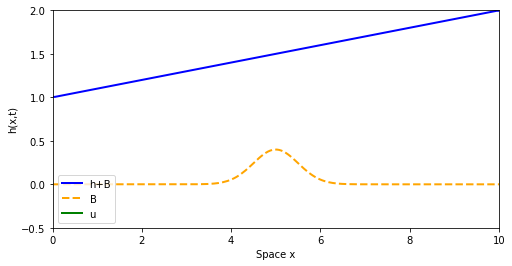

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(h)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h
line2, = ax.plot([], [], '--', color='orange', linewidth=2)  # Line plot for B
line3, = ax.plot([], [], 'g-', linewidth=2)  # Line plot for u

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((0, 10, -.5, 2))              # Set the bounds of the plot

def plot_q(n):
    line1.set_data(x, (h+B)[n])
    line2.set_data(x, B)
    #line3.set_data(x, u[n])

    return[line1, line2, line3]
    
anim=animation.FuncAnimation(fig, plot_q, frames=n)  # Animate the solution

plt.legend(['h+B', 'B', 'u'], loc=3)

#plt.show()
HTML(anim.to_jshtml())